In [1]:
import numpy as np
import hyperobjects as ho
import matplotlib.pyplot as plt
import opensim as osim

def gravitational_torque(model, state):
    """
    Calculates the gravity torque for each joint in an OpenSim model.
    Since this function does find Tau, st tau = -G -A (in static) with A the applied loads,
    if there are no applied loads then tau = -G ie G = -tau.
    --> The model should have no load applied!!!!.
    """
    # Create InverseDynamicsSolver
    solver = osim.InverseDynamicsSolver(model)    

    # Solve once for all coordinates
    gen_forces = solver.solve(state)
    return -gen_forces.to_numpy()

def station_jacobian(model, state, X, body_X):
    J = osim.Matrix()
    matter: osim.SimbodyMatterSubsystem = model.getMatterSubsystem()
    matter.calcStationJacobian(state, body_X.getMobilizedBodyIndex(), osim.Vec3(X), J)
    return J.to_numpy()

def lever_arm_matrix(state, muscles, coordinates):
    """This is already given as -L.T"""
    N_osim = [[x.computeMomentArm(state, c) for c in coordinates] for x in muscles]
    return np.array(N_osim).T

In [2]:
model = osim.Model()

b1 = osim.Body("b1",
                    1.0,
                    osim.Vec3(0, 0, 0),
                    osim.Inertia(0, 0, 0))
b2 = osim.Body("b2",
                   1.0,
                   osim.Vec3(0, 0, 0),
                   osim.Inertia(0, 0, 0))
b3 = osim.Body("b3",
                   1.0,
                   osim.Vec3(0, 0, 0),
                   osim.Inertia(0, 0, 0))

j1 = osim.PinJoint("j1",
                         model.getGround(), # PhysicalFrame
                         osim.Vec3(0, 0, 0),
                         osim.Vec3(0, 0, 0),
                         b1, # PhysicalFrame
                         osim.Vec3(0, 1, 0),
                         osim.Vec3(0, 0, 0))

j2 = osim.PinJoint("j2",
                      b1, # PhysicalFrame
                      osim.Vec3(0, 0, 0),
                      osim.Vec3(0, 0, 0),
                      b2, # PhysicalFrame
                      osim.Vec3(0, 0.5, 0),
                      osim.Vec3(0, 0, 0))

j3 = osim.PinJoint("j3",
                      b2, # PhysicalFrame
                      osim.Vec3(0, 0, 0),
                      osim.Vec3(0, 0, 0),
                      b3, # PhysicalFrame
                      osim.Vec3(0, 0.2, 0),
                      osim.Vec3(0, 0, 0))

model.addBody(b1)
model.addBody(b2)
model.addBody(b3)
model.addJoint(j1)
model.addJoint(j2)
model.addJoint(j3)

nb_muscles_per_comb = 1
nb_muscles = 3*nb_muscles_per_comb
np.random.seed(42)
for i in range(nb_muscles_per_comb):
    muscle = osim.Millard2012EquilibriumMuscle(f"m_{i}",  # Muscle name
                                           1.0,  # Max isometric force
                                           0.6,  # Optimal fibre length
                                           0.55,  # Tendon slack length
                                           0.0)  # Pennation angle
    origin = np.random.uniform(-0.5,0.5,size=3)
    insertion = np.random.uniform(-0.5,0.5,size=3)
    muscle.addNewPathPoint("origin",
                       model.getGround(),
                       osim.Vec3(*origin))
    muscle.addNewPathPoint("insertion",
                        b2,
                        osim.Vec3(*insertion))
    muscle.setName(f"m_{i}")
    model.addForce(muscle)
    
for i in range(nb_muscles_per_comb,2*nb_muscles_per_comb):
    muscle = osim.Millard2012EquilibriumMuscle(f"m_{i}",  # Muscle name
                                           1.0,  # Max isometric force
                                           0.6,  # Optimal fibre length
                                           0.55,  # Tendon slack length
                                           0.0)  # Pennation angle
    origin = np.random.uniform(-0.5,0.5,size=3)
    insertion = np.random.uniform(-0.5,0.5,size=3)
    muscle.addNewPathPoint("origin",
                       b2,
                       osim.Vec3(*origin))
    muscle.addNewPathPoint("insertion",
                        b3,
                        osim.Vec3(*insertion))
    muscle.setName(f"m_{i}")
    model.addForce(muscle)

for i in range(2*nb_muscles_per_comb,3*nb_muscles_per_comb):
    muscle = osim.Millard2012EquilibriumMuscle(f"m_{i}",  # Muscle name
                                           1.0,  # Max isometric force
                                           0.6,  # Optimal fibre length
                                           0.55,  # Tendon slack length
                                           0.0)  # Pennation angle
    origin = np.random.uniform(-0.5,0.5,size=3)
    insertion = np.random.uniform(-0.5,0.5,size=3)
    muscle.addNewPathPoint("origin",
                       b1,
                       osim.Vec3(*origin))
    muscle.addNewPathPoint("insertion",
                        b3,
                        osim.Vec3(*insertion))
    model.addForce(muscle)

model.finalizeConnections()
model.printToXML("arm33_custom.osim")

True

In [3]:
n = model.getCoordinateSet().getSize()
m = model.getMuscles().getSize()
Q = np.linspace(-180, 180, n)/180 * np.pi

state = model.initSystem()

X = [0.00722561, -0.0645789, -0.000513764] # Better adjusted
body_X = model.getBodySet().get("b3")

for i, c in enumerate(model.getCoordinateSet()):
    c: osim.Coordinate = osim.Coordinate.safeDownCast(c)
    c.setValue(state, Q[i])
    c.setDefaultValue(Q[i])
    c.setSpeedValue(state, 0.0)
    c.setDefaultSpeedValue(0.0)    

G = gravitational_torque(model, state)
Jt = station_jacobian(model, state, X, body_X).T
Jtpinv = np.linalg.pinv(Jt)
imJt = ho.AffineSpace(Jt)
N = lever_arm_matrix(state, model.getMuscles(), [c for c in model.getCoordinateSet()])
print(N)
print(np.linalg.matrix_rank(N))
print(np.linalg.matrix_rank(Jt))
print(Jt)
Jt = Jt[:,:2]
print(Jt)

[[ 1.23935276e-01  5.55111512e-17 -5.55111512e-17]
 [ 1.06160991e-01  5.55111512e-17 -1.44948761e-01]
 [ 0.00000000e+00  4.16912367e-01 -1.65306114e-01]]
3
2
[[-1.2354211   0.00722561  0.        ]
 [-0.2354211   0.00722561  0.        ]
 [ 0.2645789   0.00722561  0.        ]]
[[-1.2354211   0.00722561]
 [-0.2354211   0.00722561]
 [ 0.2645789   0.00722561]]


In [4]:
for m in model.getMuscles():
    # print(m)
    m: osim.Millard2012EquilibriumMuscle = osim.Millard2012EquilibriumMuscle.safeDownCast(m)
    # print(m.getLength(state))
    # print(m.getActiveForceLengthCurve())
    fct: osim.ActiveForceLengthCurve = m.getActiveForceLengthCurve()
    print(fct.getMinValue())
    print(fct.calcValue(1.3))

0.0
0.6840319573686932
0.0
0.6840319573686932
0.0
0.6840319573686932


Visual: no faces found, calculating faces
using provided 3d axis
[[1.         0.         1.         0.53577635]
 [0.1083125  0.         0.23331965 0.        ]
 [1.         0.         0.         1.        ]]
Visual: no faces found, calculating faces
using provided 3d axis


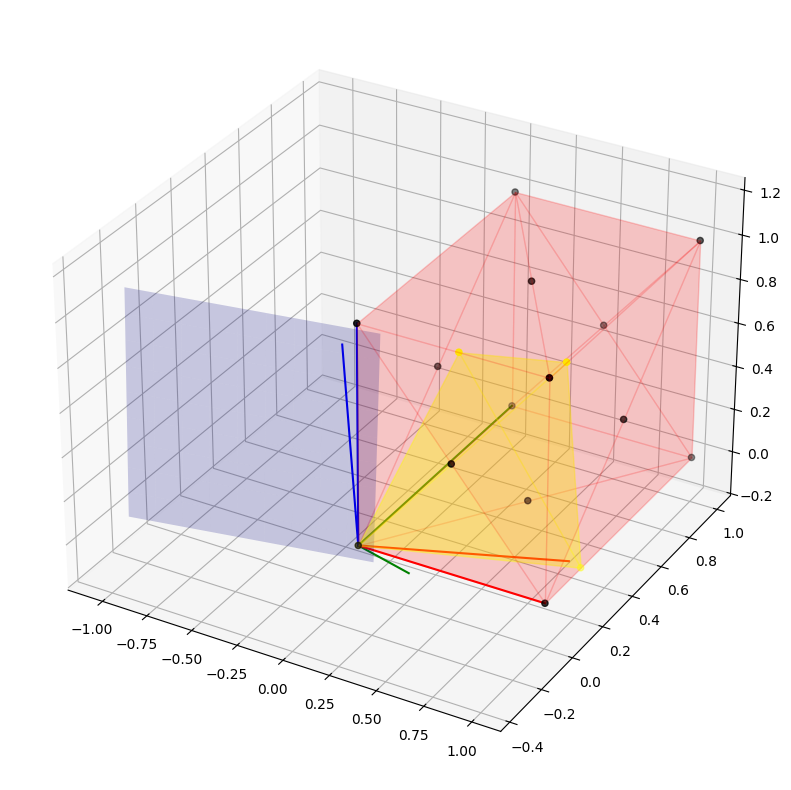

In [5]:
%matplotlib inline

from pycapacity.algorithms import iterative_convex_hull_method
from pycapacity.objects import Polytope
from pycapacity.visual import plot_polytope

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection="3d")

T = ho.Cube(3) + [0.5,0.5,0.5]
T.plot(ax, color="red", alpha=0.1)

K = ~(ho.AffineMap(N).T(~ho.AffineSpace(Jt)))
K.plot(ax, color="blue", alpha=0.2)

res = iterative_convex_hull_method(Jt, N, np.array([0.0,0,0]), np.array([1.0,1,1]), tol=0.001)
# print(res[-2]) 
print(res[-2])

# s = res[-2][:,1]
# ax.plot([0,s[0]], [0,s[1]], [0,s[2]], c="blue")
P = Polytope(vertices=res[-2])
plot_polytope(P, plot=ax, color="yellow", alpha=0.2)


# K2 = ~(ho.AffineMap(N).T(~ho.AffineSpace(Jt[:,0])))
# K2.plot(ax, color="violet", alpha=0.9)

# Gx = 10*N.T @ N[:,0]
# Gy = 10*N.T @ N[:,1]
# Gz = 10*N.T @ N[:,2]
# ax.plot([0,Gx[0]], [0,Gx[1]], [0,Gx[2]], c="red")
# ax.plot([0,Gy[0]], [0,Gy[1]], [0,Gy[2]], c="green")
# ax.plot([0,Gz[0]], [0,Gz[1]], [0,Gz[2]], c="blue")

e1_proj = K << [1,0,0]
ax.plot([0,e1_proj[0]], [0,e1_proj[1]], [0,e1_proj[2]], c="red")
e2_proj = K << [0,1,0]
ax.plot([0,e2_proj[0]], [0,e2_proj[1]], [0,e2_proj[2]], c="green")
e3_proj = K << [0,0,1]
ax.plot([0,e3_proj[0]], [0,e3_proj[1]], [0,e3_proj[2]], c="blue")

ax.plot([0,1], [0,0], [0,0], c="red")
ax.plot([0,0], [0,1], [0,0], c="green")
ax.plot([0,0], [0,0], [0,1], c="blue")

Visual: no faces found, calculating faces
using provided 3d axis
[[1.         0.         1.         0.53577635]
 [0.1083125  0.         0.23331965 0.        ]
 [1.         0.         0.         1.        ]]
Visual: no faces found, calculating faces
using provided 3d axis


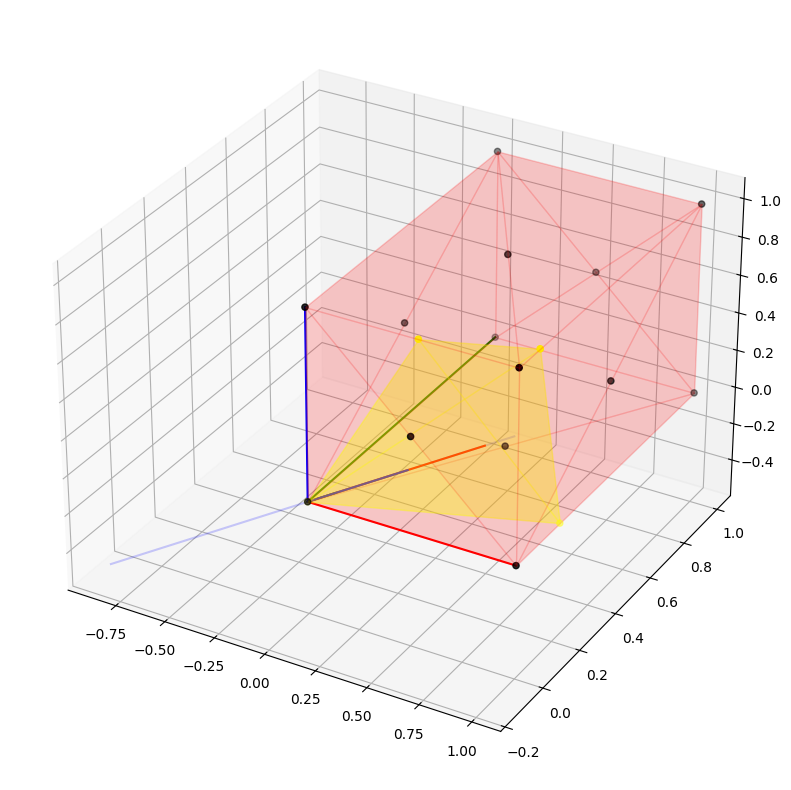

In [6]:
%matplotlib inline

from pycapacity.algorithms import iterative_convex_hull_method
from pycapacity.objects import Polytope
from pycapacity.visual import plot_polytope

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection="3d")

T = ho.Cube(3) + [0.5,0.5,0.5]
T.plot(ax, color="red", alpha=0.1)

K = ~(ho.AffineMap(N).T(~ho.AffineSpace(Jt[:,0])))
K.plot(ax, color="blue", alpha=0.2)

res = iterative_convex_hull_method(Jt, N, np.array([0.0,0,0]), np.array([1.0,1,1]), tol=0.001)
# print(res[-2]) 
print(res[-2])

# s = res[-2][:,1]
# ax.plot([0,s[0]], [0,s[1]], [0,s[2]], c="blue")
P = Polytope(vertices=res[-2])
plot_polytope(P, plot=ax, color="yellow", alpha=0.2)


# K2 = ~(ho.AffineMap(N).T(~ho.AffineSpace(Jt[:,0])))
# K2.plot(ax, color="violet", alpha=0.9)

# Gx = 10*N.T @ N[:,0]
# Gy = 10*N.T @ N[:,1]
# Gz = 10*N.T @ N[:,2]
# ax.plot([0,Gx[0]], [0,Gx[1]], [0,Gx[2]], c="red")
# ax.plot([0,Gy[0]], [0,Gy[1]], [0,Gy[2]], c="green")
# ax.plot([0,Gz[0]], [0,Gz[1]], [0,Gz[2]], c="blue")

e1_proj = K << [1,0,0]
ax.plot([0,e1_proj[0]], [0,e1_proj[1]], [0,e1_proj[2]], c="red")
e2_proj = K << [0,1,0]
ax.plot([0,e2_proj[0]], [0,e2_proj[1]], [0,e2_proj[2]], c="green")
e3_proj = K << [0,0,1]
ax.plot([0,e3_proj[0]], [0,e3_proj[1]], [0,e3_proj[2]], c="blue")

ax.plot([0,1], [0,0], [0,0], c="red")
ax.plot([0,0], [0,1], [0,0], c="green")
ax.plot([0,0], [0,0], [0,1], c="blue")

7
5
7 6 5
[[ 4.87125877  0.        ]
 [ 9.04153616  0.        ]
 [ 2.22449231  0.        ]
 [-9.11989439  0.        ]
 [-2.2231461   0.        ]
 [ 7.86776402  0.        ]
 [ 5.46114522  0.        ]]
Visual: no faces found, calculating faces
using provided 3d axis


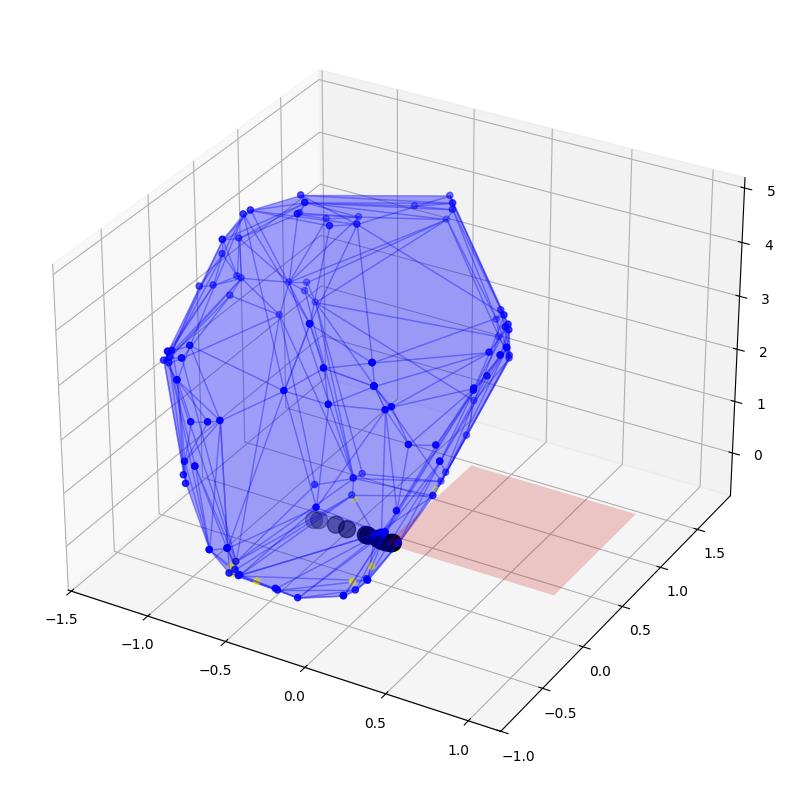

In [179]:
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection="3d")

np.random.seed(32)
p, n, m = 3, 7, 11
K_full = ho.AffineSpace(np.random.uniform(size=(m, m-(n-p))))
K_line = ho.AffineSpace(np.random.uniform(size=(m, m-(n-1))))
print(K_full.dim)
print(K_line.dim)

Jt = np.random.uniform(-10,10,size=(n, p))
Jt_plane = Jt @ np.array([[1,0], [0,1], [0,0]])
N = np.random.uniform(-15,15,size=(n,m))

K_full = ~ho.AffineMap(N).T(~ho.AffineSpace(Jt))
K_plane = ~ho.AffineMap(N).T(~ho.AffineSpace(Jt_plane))
K_line = ~ho.AffineMap(N).T(~ho.AffineSpace(Jt@np.array([1,0,0])))
print(K_full.dim, K_plane.dim, K_line.dim)


res_full = iterative_convex_hull_method(Jt, N, np.zeros(m), np.ones(m), tol=0.001)
P_full = Polytope(vertices=res_full[0])
res_plane = iterative_convex_hull_method(Jt_plane, N, np.zeros(m), np.ones(m), tol=0.01)

Jt_line = Jt[:,:2].copy()
Jt_line[:,1] = 0
print(Jt_line)
# res_line = iterative_convex_hull_method(Jt_line, N, np.zeros(m), np.ones(m), tol=0.0001)

res_line = iterative_convex_hull_method(K_line.generators, np.identity(m), np.zeros(m), np.ones(m), tol=0.1)
# res_line[-2]

# P_plane = Polytope(vertices=res_plane[0])
# print(res_full[0].shape)
ho.AffineSpace( np.array([[1,0], [0,1], [0,0]])).plot(ax, color="red", alpha=0.2)

res_l = np.unique(res_line[-2].round(2).T, axis=0).T
ax.scatter(*(np.linalg.pinv(Jt)@N@res_l), c="black", s=150)

plot_polytope(P_full, plot=ax,color="blue", alpha=0.2)
# plot_polytope(P_plane, plot=ax,color="green", alpha=0.2)
ax.scatter(*res_plane[0], c="yellow")

In [72]:
print(np.linalg.matrix_rank(res_l))
print(res_l.shape)
res_l.T

6
(11, 7)


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.33, 0.61, 0.24, 0.07, 0.46, 0.  , 0.67, 1.  , 0.  ],
       [0.  , 0.  , 0.38, 0.65, 0.16, 0.37, 0.  , 0.23, 0.58, 1.  , 0.  ],
       [0.  , 0.  , 0.4 , 0.82, 0.  , 0.21, 0.12, 0.  , 0.57, 1.  , 0.09],
       [0.  , 0.  , 0.41, 0.81, 0.  , 0.3 , 0.  , 0.08, 0.55, 1.  , 0.08],
       [0.  , 0.07, 0.51, 0.84, 0.  , 0.24, 0.  , 0.01, 0.59, 1.  , 0.  ],
       [0.24, 0.  , 0.3 , 0.63, 0.08, 0.25, 0.  , 0.  , 0.53, 1.  , 0.  ]])

In [128]:
print(K_line.dim)
print(res_l.T.shape)

for i in range(m):
    # print(i)
    center = 0.5*np.ones(m)
    ei = center.copy()
    ei[i] = 1
    ei_proj = (K_line) << ho.Point(ei)
    ei_proj = ei_proj.location.ravel()
    center_proj = (K_line) << ho.Point(center)
    center_proj = center_proj.location.ravel()

    E1 = ei - center
    E2 = ei_proj - center_proj
    # ei_proj = N.T@N@ei
    cpt = 0
    # for r in res_l.T:
    #     u = np.arccos(ei.dot(r) / np.linalg.norm(r))
    #     # u = np.linalg.norm(ei - r)
    #     # print(u*180/(np.pi/2))

    #     if u < np.pi/2:
    #         cpt += 1
        
    dist = np.linalg.norm(E1 - E2)

    # print(np.linalg.norm(ei_proj))
    an = np.arccos(E1.dot(E2)/(np.linalg.norm(E1) * np.linalg.norm(E2)))*180/(np.pi)
    print(i+1, cpt, dist, an, np.abs(an - 90/2))

5
(7, 11)
1 0 0.2835104082116254 34.54273841022705 10.457261589772948
2 0 0.4474391809410302 63.49281004121548 18.492810041215478
3 0 0.3724030728328927 48.14245101215635 3.14245101215635
4 0 0.34587519829305374 43.76882813454051 1.231171865459487
5 0 0.3940264108009256 52.00391517754826 7.003915177548258
6 0 0.4070767149048429 54.50374075190789 9.503740751907891
7 0 0.2755645536484587 33.44450897804725 11.555491021952747
8 0 0.3539488857559701 45.06412863618971 0.06412863618970732
9 0 0.4357689181865456 60.63784075237706 15.637840752377059
10 0 0.32024813281597353 39.82883473799021 5.1711652620097865
11 0 0.38271269711563305 49.944851826184774 4.944851826184774


In [180]:
import scipy
# np.random.seed(6)

# p, n, m = 3, 7, 10

# Jt = np.random.uniform(-10,10,size=(n, p))
# N = np.random.uniform(-15,15,size=(n,m))
# Jt_line = Jt@np.array([1,0,0])

K_full = ~ho.AffineMap(N).T(~ho.AffineSpace(Jt))
K_line = ~ho.AffineMap(N).T(~ho.AffineSpace(Jt_line))
# print(K_full.dim, K_line.dim)

# CF https://mathoverflow.net/questions/102153/angle-between-subspaces
Pk = (K_line).orthogonal_projection_matrix
Pk_orth = (~K_line).orthogonal_projection_matrix

B = np.identity(m)
for i, e in enumerate(B):
    e0 = ho.Line(e)
    Pe0 = e0.orthogonal_projection_matrix
    Pe0_orth = (~e0).orthogonal_projection_matrix

    nor = np.linalg.norm(Pe0_orth @ Pk, ord=np.inf)
    nor2 = np.linalg.norm(Pk_orth @ Pe0, ord=np.inf)
    # print(nor, nor2)
    print(i, (np.arcsin(nor2) * 180/np.pi).round(2))


0 59.2
1 30.26
2 26.73
3 22.42
4 22.53
5 24.38
6 36.59
7 30.54
8 51.91
9 39.26
10 33.17


In [195]:
print(p,n,m)
print(m-(n-p))
print(res_l.round(3)[:,:])

3 7 11
7
[[ 0.    0.   -0.    0.    0.    0.    0.    0.    0.    0.   -0.    0.06
   0.09  0.09]
 [ 0.    0.36  0.49  0.66  0.69  0.76  0.77  1.    1.    1.    1.    1.
   0.6   0.61]
 [ 0.    0.52  0.5   0.    0.2   0.    0.12  0.    0.    0.    0.2   0.
   0.    0.1 ]
 [ 0.    0.11  0.    0.43  0.39  0.   -0.    0.    0.    0.37  0.    0.
   0.    0.  ]
 [ 0.    1.    1.    0.75  1.    0.85  1.    0.74  1.    0.96  1.    1.
   0.87  1.  ]
 [ 0.    0.45  0.29  1.    1.    1.    1.    0.32  1.    1.    0.37  0.81
   1.    1.  ]
 [ 0.    0.58  0.41  0.57  0.7   0.62  0.69  0.    0.56  0.5   0.17  0.43
   0.7   0.76]
 [ 0.    0.2   0.23  0.72  0.68  0.8   0.76  0.67  0.93  0.91  0.63  0.76
   0.55  0.53]
 [ 0.    0.    0.11  0.    0.    0.    0.    0.35  0.11  0.15  0.33  0.23
   0.    0.  ]
 [ 0.    0.    0.    0.44  0.36  0.14  0.11  0.33  0.23  0.52  0.27  0.29
   0.12  0.1 ]
 [ 0.    0.    0.    0.   -0.    0.18  0.17  0.    0.16  0.    0.    0.
   0.    0.  ]]


In [189]:
np.unique(res_line[-2].round(2).T, axis=0).T

array([[0.  , 0.  , 0.4 ],
       [0.  , 0.  , 0.74],
       [0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.06, 0.  ],
       [0.  , 1.  , 1.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 0.36, 0.  ],
       [0.  , 0.47, 0.98],
       [0.  , 0.  , 0.66],
       [0.  , 0.47, 1.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 0.8 , 0.26]])

In [190]:
N @ np.unique(res_line[-2].round(2).T, axis=0).T

array([[ 0.        , -1.57019853,  0.62454062],
       [ 0.        , -1.41167078,  1.6624944 ],
       [ 0.        , -0.64491224,  0.36173169],
       [ 0.        , -0.72194286,  0.40048518],
       [ 0.        , -1.5943969 ,  0.88826313],
       [ 0.        , -1.38001857,  0.75715949],
       [ 0.        , -0.77319641,  0.42676673]])

In [172]:
res_line[-2].round(2)

array([[ 1.  ,  0.65,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.17,  0.  ,  0.  ,  0.  ],
       [ 0.38,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  1.  ,  0.  ,  0.  ],
       [-0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.66,  0.  ,  0.  ],
       [ 1.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.67,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ],
       [ 1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.61,  0.  ,  0.  ,  0.  ],
       [ 0.55,  0.  ,  0.  ,  0.  ],
       [ 0.94,  0.74,  0.  ,  0.  ],
       [ 1.  ,  1.  ,  0.  ,  0.  ],
       [ 1.  ,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  0.15,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ],
       [ 1.  ,  0.  ,  0.  ,  0.  ]])

In [155]:
Jt_line = Jt[:,:2].copy()
Jt_line[:,1] = 0
print(Jt_line)
res_line = iterative_convex_hull_method(Jt_line, N, np.zeros(m), np.ones(m), tol=0.01)
res_line[0]

[[0.80620128 0.        ]
 [0.20934932 0.        ]
 [0.61825477 0.        ]
 [0.74747094 0.        ]
 [0.71334959 0.        ]
 [0.53211349 0.        ]
 [0.53261727 0.        ]]


array([[ 1.38933058, -3.55300369,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [140]:
print(K_line.dim)

for i in range(m):
    ei = np.zeros(m)
    ei[i] = 1
    ei_proj = K_line << ei
    dist = np.linalg.norm(ei - ei_proj)
    print(i+1, dist)


14
1 0.6019150904927849
2 0.5699110909592379
3 0.611284653265441
4 0.6556189609857692
5 0.4018373808566109
6 0.6766838042973644
7 0.5831296870140287
8 0.49249589171008057
9 0.48414975747215766
10 0.46421996934721443
11 0.532364951957242
12 0.5703846889056157
13 0.541639693877493
14 0.45632139832797086
15 0.48096077670108933
16 0.6743177659456359
17 0.5480264982311354
18 0.5248762880541699
19 0.4527325307562451
20 0.5294809093295108


In [121]:
ho.AffineSpace(J_plane).dim_ambient

7

In [124]:
np.linalg.pinv(J.T) @ J_plane

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 7 is different from 3)

[[ 0.          0.12393528  0.12393528  0.          0.06640159]
 [ 0.          0.10616099 -0.03878777  0.         -0.08807021]
 [ 0.          0.09727385 -0.12014929  0.         -0.16530611]]
Visual: no faces found, calculating faces
using provided 3d axis
Visual: no faces found, calculating faces
using provided 3d axis


<Axes3D: >

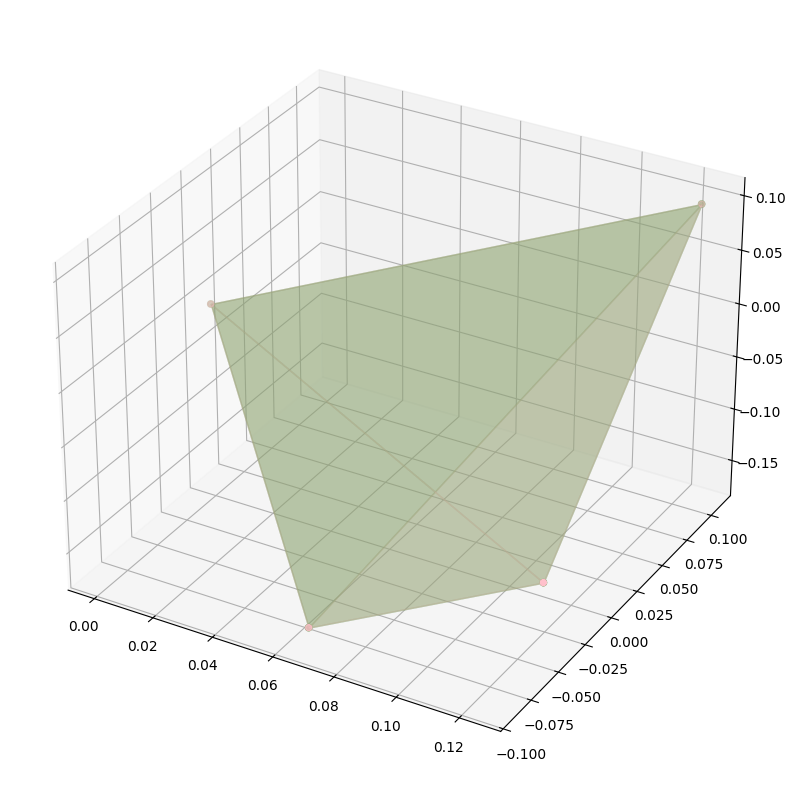

In [73]:
%matplotlib inline
import scipy
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection="3d")

# print(res[-2])
# print(res[0])
P1 = Polytope(vertices=Jt @ res[0])

# K = scipy.linalg.null_space((N.T @ scipy.linalg.null_space(Jt.T)).T)
# print(K)
res2 = iterative_convex_hull_method(K.generators, np.identity(3), 0*np.ones(3), 1*np.ones(3), tol=0.001)
# print(res2[-2])
# print(N@res2[-2])
print(N@res2[-2])
P2 = Polytope(vertices=N@res2[-2])

plot_polytope(P1, plot=ax, color="green", alpha=0.2)
plot_polytope(P2, plot=ax, color="pink", alpha=0.2)


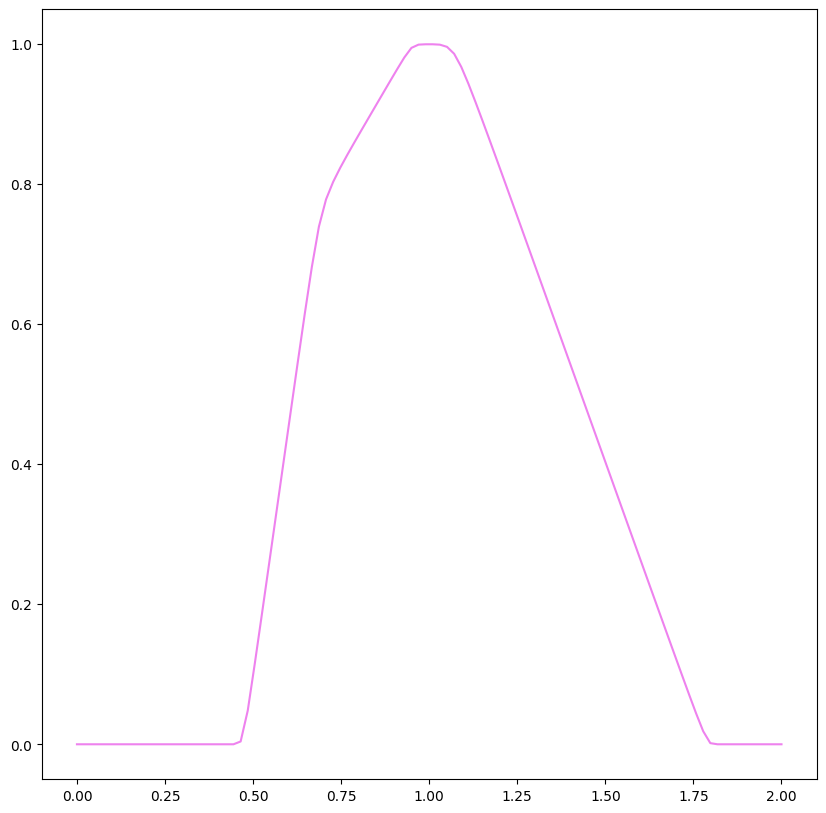

In [24]:
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)

m = model.getMuscles().get(0)
m: osim.Millard2012EquilibriumMuscle = osim.Millard2012EquilibriumMuscle.safeDownCast(m)

X = np.linspace(0, 2, 100)
activation_function: osim.ActiveForceLengthCurve = m.getActiveForceLengthCurve()


ax.plot(X, [activation_function.calcValue(x) for x in X], c="violet")

In [692]:
state = model.initSystem()

X = [0.00722561, -0.0645789, -0.000513764] # Better adjusted
body_X = model.getBodySet().get("hand")

Qs = np.zeros((300,9))
rad = np.linspace(-180, 180, Qs.shape[0])/180 * np.pi
Qs[:,4] = rad

lengths_muscles = np.zeros((Qs.shape[0], model.getForceSet().getSize()))
fiber_lengths_muscles = np.zeros((Qs.shape[0], model.getForceSet().getSize()))
fiber_force_muscles = np.zeros((Qs.shape[0], model.getForceSet().getSize()))
active_force_muscles = np.zeros((Qs.shape[0], model.getForceSet().getSize()))
passive_force_muscles = np.zeros((Qs.shape[0], model.getForceSet().getSize()))
all_K = []
all_N = []

for i, Q in enumerate(Qs):
    for k in range(9):
        model.getCoordinateSet().get(k).setDefaultValue(Q[k])
        model.getCoordinateSet().get(k).setValue(state, Q[k])
        model.getCoordinateSet().get(k).setDefaultSpeedValue(0)
        model.getCoordinateSet().get(k).setSpeedValue(state, 0)

    for muscle in model.getMuscles():
        muscle.setActivation(state, 1)
        muscle.setAppliesForce(state, True)

    model.realizePosition(state)
    model.equilibrateMuscles(state)

    for k, muscle in enumerate(model.getForceSet()):
        muscle: osim.Millard2012EquilibriumMuscle = osim.Millard2012EquilibriumMuscle.safeDownCast(muscle)
        lengths_muscles[i, k] = muscle.getLength(state)
        fiber_lengths_muscles[i, k] = muscle.getFiberLength(state)
        fiber_force_muscles[i, k] = muscle.getFiberForce(state)
        active_force_muscles[i, k] = muscle.getActiveForceLengthMultiplier(state)
        passive_force_muscles[i, k] = muscle.getPassiveForceMultiplier(state)
        

    G = gravitational_torque(model, state)
    Jt = station_jacobian(model, state, X, body_X).T
    Jtpinv = np.linalg.pinv(Jt)
    imJt = ho.AffineSpace(Jt)
    N = lever_arm_matrix(state, [osim.Millard2012EquilibriumMuscle.safeDownCast(m) for m in model.getForceSet()], [c for c in model.getCoordinateSet()])
    all_N.append(N)

    K = ~((ho.AffineMap(N).T)(~imJt))
    all_K.append(K)
    print(i, "done")




0 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
51 done
52 done
53 done
54 done
55 done
56 done
57 done
58 done
59 done
60 done
61 done
62 done
63 done
64 done
65 done
66 done
67 done
68 done
69 done
70 done
71 done
72 done
73 done
74 done
75 done
76 done
77 done
78 done
79 done
80 done
81 done
82 done
83 done
84 done
85 done
86 done
87 done
88 done
89 done
90 done
91 done
92 done
93 done
94 done
95 done
96 done
97 done
98 done
99 done
100 done
101 done
102 done
103 done
104 done
105 done
106 done
107 done
108 done
109 done
110 done
111 done
112 done
113 done
114 done
115 done
116 done
117 done
118 done
119 done
120 done
121 done
122 done
123

In [706]:
results = np.zeros((len(all_K), nb_muscles))
R = []
for i, K in enumerate(all_K):
    # print(K.location)
    # K = ho.AffineSpace(K_.generators, 0.5 * np.ones_like(K_.location))
    ge = K.basis
    # print(ge.round(2))
    u, s, vt = np.linalg.svd(ge)
    # print(s)
    # break
    s = np.array(s.tolist() + [0.1 for _ in range(nb_muscles - len(s))])

    E = ho.Ellipsoid(u @ np.diag(s))

    N = all_N[i]
    Proj = K.orthogonal_projection_matrix
    S = ho.Sphere(nb_muscles, r = 1, location=0.5*np.ones(nb_muscles))
    E = S & K
    # print(E)
    if E is None:
        R.append(np.zeros(nb_muscles))
    else:
        # print(E.location.ravel().tolist())
        # print(E.embedded_sphere_transformation.shape)
        u, s, vt = np.linalg.svd(E.embedded_sphere_transformation)
        # print(s.round(2))

        # D = np.zeros(nb_muscles)
        # D[k] = 1
        I2 = E.embedded_sphere_transformation @ np.identity(nb_muscles)
        print(I2.round(2)[:,0].ravel())
        I2_norm_col = np.linalg.norm(I2.T, axis=0)
        # print(I2_norm_col)
        R.append(I2_norm_col.ravel().tolist())
    K_orth = ~K
    Proj_orth = K_orth.orthogonal_projection_matrix

    T = np.ones(nb_muscles)
    T_in_torques = N@T

    u, s, vt = np.linalg.svd(all_N[i].T)
    # print(u.shape, s.shape, vt.shape)
    # Ell = ho.Ellipsoid(np.diag(s)@vt)
    # print(K.dim)
    for k, m in enumerate(model.getForceSet()):
        m: osim.Millard2012EquilibriumMuscle = osim.Millard2012EquilibriumMuscle.safeDownCast(m)

        D = np.zeros(nb_muscles)
        D[k] = 1
        
        # print(m.getMaxIsometricForce())
        P1 = Proj @ (m.getOptimalFiberLength() * D)
        l = np.linalg.norm(P1, ord=2)
        # print(l)
        # print(np.linalg.norm(P1, ord=np.inf), np.linalg.norm(P1, ord=2), np.linalg.norm(P1) > np.sqrt(2)/2)

        # D2 = Proj@D
        # D2 = D2 / np.linalg.norm(D2)
        # D2 = E.embedded_sphere_transformation @ D2
        # l =  np.linalg.norm(D2)


        # L = ho.Line(D)
        # R = L & Ell
        # P1 = R.generators.ravel()*D
        # P2 = R.generators.ravel()*(-D)
        # l = np.linalg.norm(D) / np.linalg.norm(P1)
        # else:
        #     l = np.linalg.norm(D) / np.linalg.norm(P2)


        # L = ho.Line(D)
        # print(np.sign(P1@D))

        # # print(np.sign(T_in_torques@N[:,k]))
        # L = ho.Line(D)
        # R = L & E
        # P1 = R.generators.ravel()*D
        # P2 = R.generators.ravel()*(-D)
        # if np.sign(T_in_torques@N[:,k]) >= 0:
        #     l = np.linalg.norm(D) / np.linalg.norm(P1)
        # else:
        #     l = np.linalg.norm(D) / np.linalg.norm(P2)

        # l1 = np.linalg.norm(D - P1)
        # l2 = np.linalg.norm(D - P2)
        # if np.sign(T_in_torques@N[:,k]) <= 0:
        #     l = np.min([l1, l2])
        # else:
        #     l = np.max([l1,l2])
        # l = l1

        # L = ho.Line(D)
        # R = L & E
        # P1 = R.generators.ravel()*D
        # P2 = R.generators.ravel()*(-D)
        # if P1.dot(D) >= 0:
        #     l = np.linalg.norm(D) / np.linalg.norm(P1)
        # else:
        #     l = np.linalg.norm(D) / np.linalg.norm(P2)

        # l1 = np.linalg.norm(D - P1)
        # l2 = np.linalg.norm(D - P2)
        # print(np.sign(D@P1), np.sign(D@P2))
        # print(l1.round(2), l2.round(2))
        # l = np.min([l1, l2])
        # l = l1

        # own_lever_arm = N.T @ N[:,k]
        # l = np.linalg.norm(D - own_lever_arm)
        # print(l)

        # P1 = Proj_orth @ D
        # l = np.linalg.norm(P1 - D)
        results[i, k] = l
    # break
# R = np.array(R)

[-0.24  0.   -0.01 -0.03 -0.02 -0.02 -0.05 -0.13 -0.01  0.21  0.12  0.03
  0.04  0.04  0.04  0.03  0.06  0.03 -0.08  0.   -0.15 -0.11 -0.06  0.06
  0.05 -0.03 -0.12 -0.08  0.11  0.01]
[-0.09  0.14 -0.06  0.08  0.01  0.06  0.01  0.04  0.06  0.15 -0.05  0.11
  0.05  0.04 -0.14 -0.08  0.03 -0.13 -0.03 -0.14  0.08 -0.11  0.14 -0.04
  0.07  0.06  0.14  0.04 -0.09 -0.09]
[ 0.07  0.01 -0.15  0.2  -0.06 -0.03 -0.16 -0.03  0.02  0.1  -0.03 -0.08
  0.11  0.06 -0.02 -0.13 -0.07 -0.06  0.   -0.04  0.1   0.04 -0.16 -0.1
  0.09  0.04 -0.11 -0.07  0.04 -0.09]
[-0.03 -0.07  0.02 -0.05  0.23  0.04 -0.11  0.08  0.08  0.1   0.08 -0.05
 -0.05  0.08  0.02  0.07 -0.06 -0.2  -0.02  0.17  0.08 -0.14  0.03  0.
 -0.03 -0.05 -0.11 -0.02  0.03  0.05]
[-0.01  0.01  0.09 -0.09  0.12  0.05  0.05 -0.11 -0.03 -0.04 -0.04 -0.04
  0.06  0.13  0.2   0.05 -0.11 -0.11  0.05  0.12  0.07 -0.03 -0.03 -0.09
 -0.01 -0.14 -0.21  0.07  0.06  0.05]
[-0.28  0.01 -0.02  0.01  0.07 -0.11 -0.   -0.05  0.08 -0.11  0.03  0.12
  0.04  0.

In [722]:
R.round(2)

array([[0.46, 0.47, 0.47, ..., 0.45, 0.46, 0.46],
       [0.42, 0.42, 0.43, ..., 0.42, 0.42, 0.42],
       [0.43, 0.43, 0.43, ..., 0.42, 0.42, 0.43],
       ...,
       [0.44, 0.44, 0.45, ..., 0.43, 0.43, 0.44],
       [0.41, 0.42, 0.42, ..., 0.4 , 0.41, 0.41],
       [0.42, 0.43, 0.43, ..., 0.42, 0.42, 0.42]])

In [710]:
R = np.array(R).T
R.shape

(30, 300)

In [644]:
print(active_force_muscles[:,0].round(2).tolist())
print((fiber_force_muscles[:,0]/m.getMaxIsometricForce()).round(2).tolist())

[0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.78, 0.78, 0.78, 0.78, 0.77, 0.77, 0.77, 0.77, 0.76, 0.76, 0.76, 0.76, 0.75, 0.75, 0.75, 0.75, 0.74, 0.74, 0.74, 0.73, 0.73, 0.73, 0.73, 0.72, 0.72, 0.72, 0.71, 0.71, 0.71, 0.7, 0.7, 0.7, 0.69, 0.69, 0.69, 0.68, 0.68, 0.68, 0.67, 0.67, 0.67, 0.66, 0.66, 0.66, 0.65, 0.65, 0.65, 0.64, 0.64, 0.64, 0.63, 0.63, 0.62, 0.62, 0.62, 0.62, 0.61, 0.61, 0.61, 0.6, 0.6, 0.6, 0.59, 0.59, 0.59, 0.58, 0.58, 0.58, 0.57, 0.57, 0.57, 0.57, 0.56, 0.56, 0.56, 0.55, 0.55, 0.55, 0.55, 0.54, 0.54, 0.54, 0.54, 0.53, 0.53, 0.53, 0.53, 0.53, 0.52, 0.52, 0.52, 0.52, 0.52, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.49, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.52, 0.52, 0.52, 0.52, 0.52,

[0.73, 0.73, 0.73, 0.72, 0.72, 0.72, 0.71, 0.71, 0.71, 0.7, 0.7, 0.69, 0.69, 0.69, 0.68, 0.68, 0.67, 0.67, 0.67, 0.66, 0.66, 0.65, 0.65, 0.64, 0.64, 0.63, 0.63, 0.63, 0.62, 0.62, 0.61, 0.61, 0.6, 0.6, 0.59, 0.59, 0.58, 0.58, 0.57, 0.57, 0.56, 0.56, 0.55, 0.55, 0.54, 0.54, 0.53, 0.52, 0.52, 0.51, 0.51, 0.5, 0.5, 0.49, 0.49, 0.48, 0.48, 0.47, 0.47, 0.46, 0.46, 0.45, 0.44, 0.44, 0.43, 0.43, 0.42, 0.42, 0.41, 0.41, 0.4, 0.4, 0.39, 0.39, 0.38, 0.38, 0.37, 0.37, 0.36, 0.36, 0.35, 0.35, 0.35, 0.34, 0.34, 0.33, 0.33, 0.33, 0.32, 0.32, 0.32, 0.31, 0.31, 0.31, 0.3, 0.3, 0.3, 0.3, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.3, 0.3, 0.3, 0.3, 0.3, 0.31, 0.31, 0.31, 0.32, 0.32, 0.32, 0.33, 0.33, 0.33, 0.34, 0.34, 0.35, 0.35, 0.36, 0.36, 0.36, 0.37, 0.37, 0.38, 0.38, 0.39, 0.39, 0.4, 0.4, 0.41, 0.41, 0.42, 0.42, 0.43, 0.44, 0.44, 0.45, 0.45, 0.46, 0.46, 0.47, 0.47, 0.48, 0.48, 0.49, 0.49, 0.5, 0.5, 0.51, 0.52, 0.52, 0.53, 0.53, 0.54, 

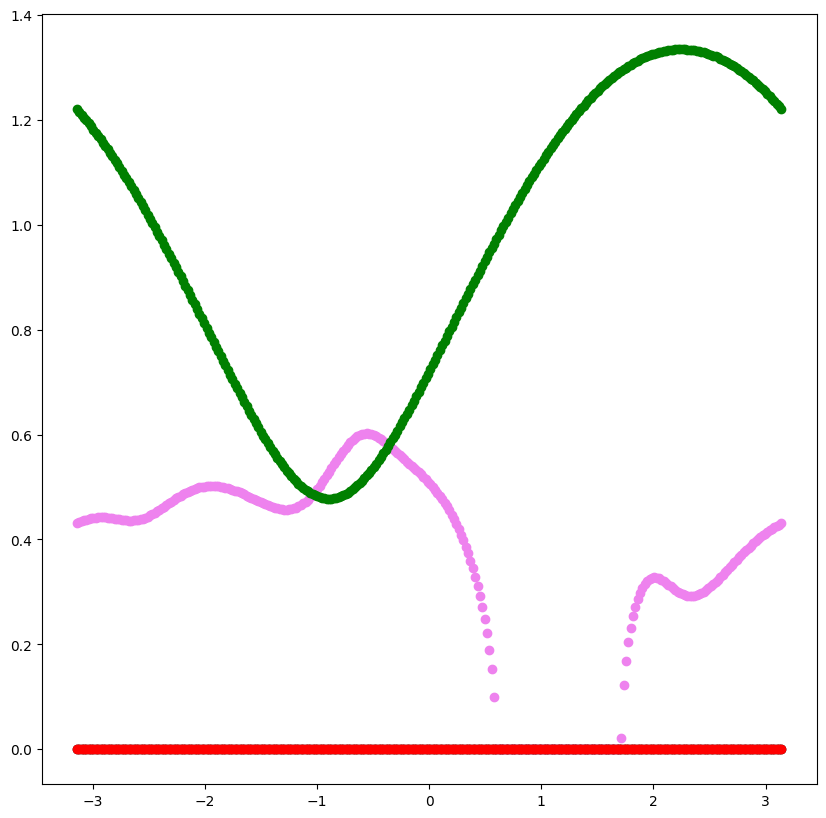

In [721]:
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
k = 25

m = model.getMuscles().get(k)
m: osim.Millard2012EquilibriumMuscle = osim.Millard2012EquilibriumMuscle.safeDownCast(m)
ra = np.linalg.norm((1/(results[:, k]) - lengths_muscles[:,k]/m.getOptimalFiberLength()).reshape((-1,1)), axis=1)
# print(ra)
ax.scatter(rad, R[k, :], c="violet")
# ax.scatter(rad, ra, c="violet")
# ax.scatter(rad, 1/(results[:, k]), c="pink")
# ax.scatter(rad, (results[:, k]), c="pink")
ax.scatter(rad, active_force_muscles[:,k], c="black")
ax.scatter(rad, fiber_force_muscles[:,k]/m.getMaxIsometricForce(), c="red")
ax.scatter(rad, lengths_muscles[:,k]/m.getOptimalFiberLength(), c="green")

print(lengths_muscles[:,k].round(2).tolist())
print(m.getOptimalFiberLength())

# ax.set_ylim(0,1)
# ax.scatter(list(range(results.shape[0])), 1*fiber_lengths_muscles[:,k], c="green")
# ax.scatter(list(range(results.shape[0])), 1*fiber_force_muscles[:,k], c="green")

In [38]:
lengths_muscles.shape

(300, 30)

In [29]:
Qs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])